In [1]:
import cv2,sys,dlib,time,math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import faceBlendCommon as fbc
import matplotlib
matplotlib.rcParams['figure.figsize'] = (8.0,8.0)
matplotlib.rcParams['image.cmap'] = 'gray'
matplotlib.rcParams['image.interpolation'] = 'bilinear'

In [2]:
# Landmark model location
PREDICTOR_PATH =  "shape_predictor_68_face_landmarks.dat"

# Get the face detector
faceDetector = dlib.get_frontal_face_detector()
# The landmark detector is implemented in the shape_predictor class
landmarkDetector = dlib.shape_predictor(PREDICTOR_PATH)

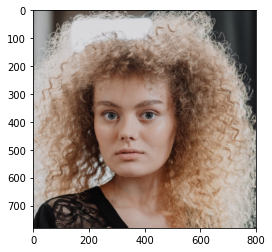

In [3]:
im = cv2.imread("girl-no-makeup.jpg")

imDlib = cv2.cvtColor(im,cv2.COLOR_BGR2RGB)
plt.imshow(imDlib)

In [4]:
points = fbc.getLandmarks(faceDetector, landmarkDetector, imDlib)
print(points)

[(216, 375), (217, 411), (224, 446), (233, 480), (242, 515), (258, 547), (283, 574), (313, 594), (350, 600), (390, 595), (430, 579), (464, 557), (488, 524), (501, 487), (508, 447), (513, 408), (514, 369), (223, 343), (241, 326), (268, 325), (293, 333), (317, 346), (362, 345), (389, 331), (418, 321), (449, 321), (474, 336), (338, 374), (337, 397), (335, 419), (333, 442), (315, 465), (326, 468), (337, 471), (351, 468), (364, 465), (252, 378), (268, 368), (289, 369), (307, 385), (287, 390), (266, 389), (382, 384), (401, 369), (423, 367), (441, 375), (426, 387), (404, 389), (293, 517), (310, 503), (327, 496), (340, 500), (353, 496), (376, 502), (401, 514), (377, 528), (356, 535), (341, 536), (326, 535), (310, 530), (303, 516), (327, 512), (340, 512), (354, 511), (391, 513), (354, 512), (341, 513), (327, 513)]


In [5]:
def createEyeMask(eyeLandmarks, im):
    leftEyePoints = eyeLandmarks
    eyeMask = np.zeros_like(im)
    cv2.fillConvexPoly(eyeMask, np.int32(leftEyePoints), (255, 255, 255))
    eyeMask = np.uint8(eyeMask)
    return eyeMask

def findIris(eyeMask, im, thresh):
    r = im[:,:,2]
    _, binaryIm = cv2.threshold(r, thresh, 255, cv2.THRESH_BINARY_INV)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (4,4))
    morph = cv2.dilate(binaryIm, kernel, 1)
    morph = cv2.merge((morph, morph, morph))
    morph = morph.astype(float)/255
    eyeMask = eyeMask.astype(float)/255
    iris = cv2.multiply(eyeMask, morph)
    return iris

def findCentroid(iris):
    M = cv2.moments(iris[:,:,0])
    cX = int(M["m10"] / M["m00"])
    cY = int(M["m01"] / M["m00"])
    centroid = (cX,cY)
    return centroid

def createIrisMask(iris, centroid):
    cnts, _ = cv2.findContours(np.uint8(iris[:,:,0]), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    flag = 10000
    final_cnt = None
    for cnt in cnts:
        (x,y),radius = cv2.minEnclosingCircle(cnt)
        distance = abs(centroid[0]-x)+abs(centroid[1]-y)
        if distance < flag :
            flag = distance
            final_cnt = cnt
        else:
            continue
    (x,y),radius = cv2.minEnclosingCircle(final_cnt)
    center = (int(x),int(y))
    radius = int(radius) - 2

    irisMask = np.zeros_like(iris)
    inverseIrisMask = np.ones_like(iris)*255
    cv2.circle(irisMask,center,radius,(255, 255, 255),-1)
    cv2.circle(inverseIrisMask,center,radius,(0, 0, 0),-1)
    irisMask = cv2.GaussianBlur(irisMask, (5,5), cv2.BORDER_DEFAULT)
    inverseIrisMask = cv2.GaussianBlur(inverseIrisMask, (5,5), cv2.BORDER_DEFAULT)

    return irisMask, inverseIrisMask

def changeEyeColor(im, irisMask, inverseIrisMask):
    imCopy = cv2.applyColorMap(im, cv2.COLORMAP_TWILIGHT_SHIFTED)
    imCopy = imCopy.astype(float)/255
    irisMask = irisMask.astype(float)/255
    inverseIrisMask = inverseIrisMask.astype(float)/255
    im = im.astype(float)/255
    faceWithoutEye = cv2.multiply(inverseIrisMask, im)
    newIris = cv2.multiply(irisMask, imCopy)
    result = faceWithoutEye + newIris
    return result

def float642Uint8(im):
    im2Convert = im.astype(np.float64) / np.amax(im)
    im2Convert = 255 * im2Convert 
    convertedIm = im2Convert.astype(np.uint8)
    return convertedIm

# Create eye mask using eye landmarks from facial landmark detection
leftEyeMask = createEyeMask(points[36:42], im)
rightEyeMask = createEyeMask(points[43:49], im)

# Find the iris by thresholding the red channel of the image within the boundaries of the eye mask
leftIris = findIris(leftEyeMask, im, 40)
rightIris = findIris(rightEyeMask, im, 50)

# Find the centroid of the binary image of the eye
leftIrisCentroid = findCentroid(leftIris)
rightIrisCentroid = findCentroid(rightIris)

# Generate the iris mask and its inverse mask
leftIrisMask, leftInverseIrisMask = createIrisMask(leftIris, leftIrisCentroid)
rightIrisMask, rightInverseIrisMask = createIrisMask(rightIris, rightIrisCentroid)

# Change the eye color and merge it to the original image
coloredEyesLady = changeEyeColor(im, rightIrisMask, rightInverseIrisMask)
coloredEyesLady = float642Uint8(coloredEyesLady)
coloredEyesLady = changeEyeColor(coloredEyesLady, leftIrisMask, leftInverseIrisMask)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


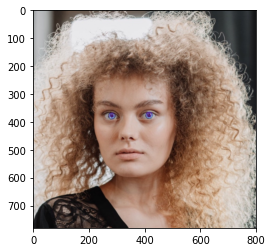

In [7]:
plt.imshow(coloredEyesLady[:,:,::-1])

Text(0.5,1,'Right Iris Mask Inverse')

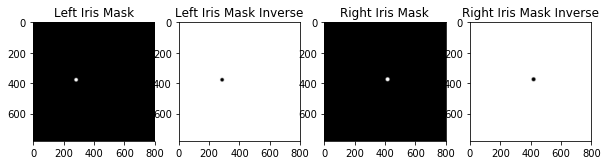

In [9]:
plt.figure(figsize=(10,10))
plt.subplot(141);plt.imshow(np.float32(leftIrisMask) / 255.0);plt.title("Left Iris Mask")
plt.subplot(142);plt.imshow(np.float32(leftInverseIrisMask) / 255.0);plt.title("Left Iris Mask Inverse")
plt.subplot(143);plt.imshow(np.float32(rightIrisMask) / 255.0);plt.title("Right Iris Mask")
plt.subplot(144);plt.imshow(np.float32(rightInverseIrisMask) / 255.0);plt.title("Right Iris Mask Inverse")